> **Notebook source:** First encountered during the [Art and Machine Learning](https://sites.google.com/site/artml2018/) class at CMU, which in turn sourced this notebook from the great [Machine Learning 4 Artists](https://ml4a.github.io/guides/).



# Reverse image search and retrieval

This notebook will show you how you can use a convolutional neural network (convnet) to search through a large collection of images. Specifically, it will show you how you can retrieve a set of images which are similar to a query image, returning you its `n` nearest neighbors in terms of image content.

### Installation and dependencies

The code has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [scikit-learn](scikit-learn.org)
 * [keras](https://keras.io)
 * [Pillow](https://python-pillow.org/)
 * [matplotlib](http://matplotlib.org)
 * [cPickle](https://docs.python.org/2/library/pickle.html)

### Prepare dataset

Finally, prepare a folder of images to do the analysis on. If you don't have one, you may download and extract the [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) containing roughly 9000 images in 101 categories. To download that dataset, run the following commands:

In [0]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xvzf 101_ObjectCategories.tar.gz

In [0]:
%matplotlib inline
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

Using TensorFlow backend.


We will load a previously-trained neural network, that of VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

Once the network is loaded, we can take a look at the architecture of the network by running `model.summary()`.

In [0]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

553467904/553467096 [==============================] - 35s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

The summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). 

To see it in action, let's load an image and input it into the network. To help us do this, we will create a function `get_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [0]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We load an image into memory, convert it into an input vector, and see the model's top 5 predictions for it.

In [0]:
#from IPython.display import display 
#from PIL import Image
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

In [0]:
!wget https://github.com/previtus/cci_exploring_machine_intelligence/raw/master/week03_convolutional-nns/kitty.jpg

In [0]:
!ls

101_ObjectCategories  101_ObjectCategories.tar.gz  kitty.jpg  sample_data


40960/35363 [==================================] - 0s 0us/step
predicted Egyptian_cat with probability 0.213
predicted kit_fox with probability 0.213
predicted tabby with probability 0.138
predicted red_fox with probability 0.107
predicted tiger_cat with probability 0.098


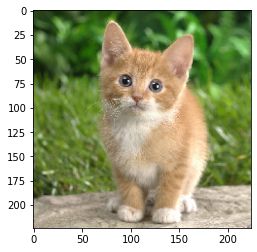

In [0]:
img, x = get_image("kitty.jpg")
predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

Now we will remove the top classification layer from our network, leaving the last fully-connected layer, "fc2 (Dense)" as the new output layer. The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. 

Note about memory: although we instantiate a new object with most of the weights of our large model, it does not actually duplicate all the weights of the previous network into memory. 

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [0]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer in VGG16. Let's plot the array as well.

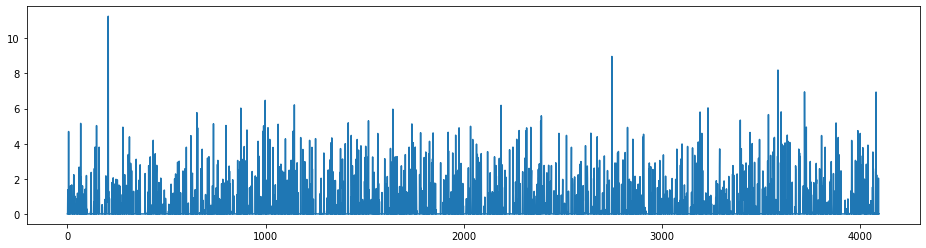

In [0]:
img, x = get_image("kitty.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

Next, we will load all of the images in a directory, and use `feature_extractor` to get a feature vector for each one. If you have your own folder of images you want to analyze, change the path of `images_path` and it will search recursively through all the folders in it. Set `max_num_images` to cap it at some maximum number of images to load (it will grab a random subset of `max_num_images` is less than the number of images in your directory.

If you are using `101_ObjectCategories`, make sure you have followed the instructions above to download it, and make sure the path matches correctly.

In [0]:
images_path = './101_ObjectCategories'
#max_num_images = 10000
max_num_images = 1000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1000 images to analyze


The next part will take the longest. We iterate through and extract the features from all the images in our `images` array, placing them into an array called `features`. 

In [0]:
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

Once that is done, we will take our `n`x4096 matrix of features (where `n` is the number of images), and apply [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to it, and keep the first 300 principal components, creating an `n`x300 matrix called `pca_features`. 

The purpose of principal component analysis is to reduce the dimensionality of our feature vectors. This reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up. 



Let's do a query. What we'll do is define a function which returns the num_results closest images to a query image, with repsect to those images contents. What it dos is: for the given query image, it will take its PCA-activations, and compute the euclidean distance between it and every other set of PCA-activations, then return the best ones.
We also define a helper function get_concatenated_images which creates a thumbnail of a set of images, so we can display the results.

In [0]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Thus we can define a new function `get_closest_images`, which will compute the euclidean distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [0]:
def get_closest_images(query_image_idx, features, num_results=5):
    distances = [ distance.euclidean(features[query_image_idx], feat) for feat in features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


Finally we can do a query on a randomly selected image in our dataset.

Text(0.5, 1.0, 'result images')

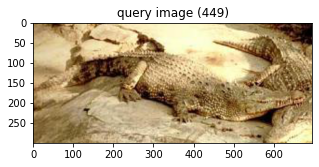

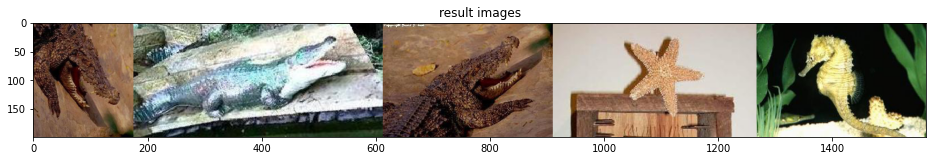

In [0]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx, pca_features)
#idx_closest = get_closest_images(query_image_idx, features)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

# Bonus: Shortest path between images


This notebook demonstrates how, given a query of two images, to find a sequence of images between them whose visual changes are as gradual as possible.

The methodology is inspired by and (roughly) reverse-engineered from [X Degrees of Separation](https://artsexperiments.withgoogle.com/xdegrees/), a work by [Mario Klingemann](http://quasimondo.com/) and [Simon Doury](http://www.simondoury.com/) for [Google Arts & Culture Experiments](https://artsexperiments.withgoogle.com/). X Degrees of Separation finds smooth paths through images taken from museum collections.

### Strategy

The approach to the problem is the following:

1) Analyze all images in your dataset, extracting a feature vector for each one from the pre-classification fully-connected layer of a trained convolutional neural network. This part is already done in the previous part.

2) For each image, find its `k` nearest neighbors, i.e. the `k` neighboring images which have the smallest cosine distance from it.

3) Build a [graph](https://en.wikipedia.org/wiki/Graph_&#40;discrete_mathematics&#41;) whose vertices are the images and whose edges are the connections between nearest-neighbors found in step 2. 

4) At run-time, given a query of two images, find the shortest path through the graph between them, using the cosine distance as distance metric. That the vertices in the graph are not fully-connected ensures that it does not return the trivial direct path between the two endpoints.

The upside to this strategy is that it's relatively straightforward, easy to implement, and fast at run-time. The downside is that it doesn't guarantee that there is a path between any two images, since it is possible for some regions of the image space to become isolated from the larger grid if they are too self-similar. Additionally, for image sets which are unevenly distributed, the simple kNN threshold may produce very densely connected clusters. There are more sophisticated approaches which try to ensure that individual edges are not too long or too short, but for the sake of simplicity, we take the easier kNN approach.


In [0]:
!apt-get install -y libigraph0-dev
!pip install python-igraph

from igraph import *

Again print out our data:

In [0]:
for i, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))


image: ./101_ObjectCategories/flamingo_head/image_0016.jpg, features: -11.55,-9.86,7.85,-8.68... 
image: ./101_ObjectCategories/flamingo_head/image_0044.jpg, features: -2.02,2.61,-0.68,-5.53... 
image: ./101_ObjectCategories/flamingo_head/image_0020.jpg, features: -3.47,-9.46,11.17,1.46... 
image: ./101_ObjectCategories/flamingo_head/image_0022.jpg, features: 1.77,-13.46,13.38,-1.23... 
image: ./101_ObjectCategories/flamingo_head/image_0026.jpg, features: -1.97,-15.05,5.66,4.94... 


In [0]:
""" Select smaller subset?
num_images = 10000

if len(images) > num_images:
    sort_order = sorted(random.sample(xrange(len(images)), num_images))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]
"""

Next, we are going to build our graph. The graph will contain one vertex for every image. The edges of the graph are found by taking the `k` nearest neighbor images to each image in the set, and adding an edge between them whose distance is given by cosine distance.

Here we set `kNN = 30` which means that we save 30 neighbor images. There are tradeoffs between lower and higher values of `kNN`. If `kNN` is very low, it helps to ensure that consecutive images in a path are as similar as possible, at the expense of making the paths longer in total nodes traversed, since low `kNN` restricts edges to a very small number of neighbors. However, there is increased risk that some regions are not connected to the rest of the graph and therefore unreachable in a query. If `kNN` is high, more nodes are connected to each other, and therefore paths will be shorter and more likely to exist, however there may be more visually dissimilar jumps between consecutive neighbors.

In [0]:
kNN = 30

graph = Graph(directed=True)
graph.add_vertices(len(images))

for i in tqdm(range(len(images))):
    distances = [ distance.cosine(pca_features[i], feat) for feat in pca_features ]
    idx_kNN = sorted(range(len(distances)), key=lambda k: distances[k])[1:kNN+1]
    for j in idx_kNN:
        graph.add_edge(i, j, weight=distances[j])
    
summary(graph)

Now we can do a query. We'll just pick two random indices (`idx1` and `idx2`) and run `igraph`'s `get_shortest_paths` method, using the cosine distance ('weight' as the `weights`).

Comparing 999 with 475


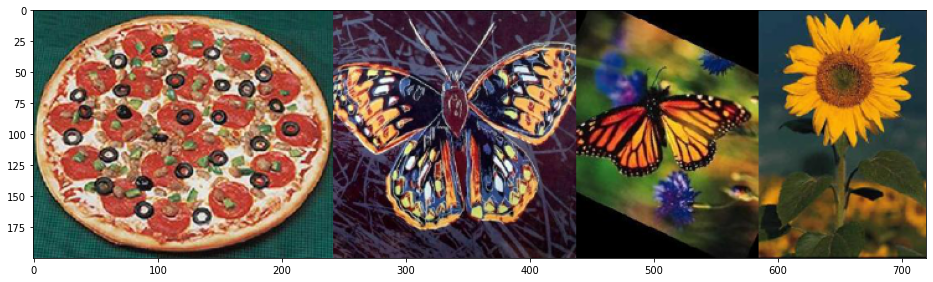

In [0]:
# pick two random indices
idx1 = int(len(images) * random.random())
idx2 = int(len(images) * random.random())

# run get_shortest_paths
path = graph.get_shortest_paths(idx1, to=idx2, mode=OUT, output='vpath', weights='weight')[0]

# retrieve the images, concatenate into one, and display them
results_image = get_concatenated_images(path, 200)
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
print("Comparing", idx1, "with", idx2)

Depending on how low you set your kNN you may have occasional errors where a path cannot be found between two isolated nodes. But with kNN>=30 this appears to be a rare event.

Not all paths are going to be very interesting. This depends greatly on the character of your image set. Some image sets (like CalTech-101 or CalTech-256) are very highly clustered around object categories, which means there may not always be good candidates between two image classes. Datasets which have more variety tend to work better for this reason.